In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.mp.linear import LinearExpr
import import_ipynb
import Methods as mt
%matplotlib inline

importing Jupyter notebook from Methods.ipynb


In [2]:
#Leitura das Instâncias
veiculos = pd.read_csv("k_50",index_col=0)
vitimas = pd.read_csv("v_15",index_col=0)
pontos = pd.read_csv("n_300",index_col=0)
hospitais = veiculos["Inicial"].unique()

In [3]:
#Criação da Matriz de Distância
_DistanceMatrix = pd.DataFrame(0,index=pontos.index,columns=pontos.index,dtype=float)

In [4]:
#Popula a Matriz de Distância
for i in _DistanceMatrix.index:
    for j in pontos.loc[i][2:].values:
        x = (pontos.loc[i]["x"]-pontos.loc[int(j)]["x"])**2
        y = (pontos.loc[i]["y"]-pontos.loc[int(j)]["y"])**2
        _DistanceMatrix.loc[i][j] = ((x+y)**(1/2))

# Modelagem

In [5]:
vrp = Model("Ambulancias-VRP") #Modelo

In [6]:
#Matriz com as variáveis de decisão principais
_DecisionCube = vrp.binary_var_cube(_DistanceMatrix.index,_DistanceMatrix.index,veiculos.index,"Arc")

In [ ]:
#Função Objetivo
vrp.minimize(vrp.sum(_DecisionCube[i,j,k]*_DistanceMatrix.loc[i][j] 
                     for i in _DistanceMatrix.index 
                     for j in _DistanceMatrix.index 
                     for k in veiculos.index))

In [ ]:
forbidden = LinearExpr(vrp)   #Arcos proíbidos

for k in veiculos.index:
    for i in _DistanceMatrix.index:
        
        flux = LinearExpr(vrp)    #Conservação de Fluxo
        match = LinearExpr(vrp)   #Restrição de Compatibilidade
        for j in _DistanceMatrix.index:
            
            if _DistanceMatrix.loc[i][j] > 0:    #Verifica se o arco existe
                
                if i in vitimas["Ponto"].values: #Se nodo 'i' for uma vítima:
                    match+=_DecisionCube[j,i,k]  #Adiciona os arcos 'jik' em 'match'
                    flux +=_DecisionCube[j,i,k]  #Subtrai o arco de chegada em 'i'
                
                elif i == veiculos.loc[k]["Inicial"]: #Se o nodo 'i' for um hospital
                    flux += _DecisionCube[i,j,k]      #Adiciona o arco de saída de 'i'
                
                elif j == veiculos.loc[k]["Inicial"]: #Se o nodo 'j' for o ponto de saida de 'k'
                    forbidden += _DecisionCube[i,j,k] #Retira o arco 'ij' da solução
                    flux -=_DecisionCube[j,i,k]       #Coloca o arco de saída de 'j' no fluxo
                    
                else:                                 #Se nenhum desses casos se aplicar
                    flux+=_DecisionCube[i,j,k]-_DecisionCube[j,i,k] #Fluxo normal
                
                    
            else:                               #Se o arco não existir
                forbidden += _DecisionCube[i,j,k]#Tira ele da solução
                         
        if i in vitimas["Ponto"].values: #Se nodo 'i' for uma vítima
            #Permite 'k' chegar em 'i' no máximo 1 vez
            vrp.add_constraint(flux<=1,"ChegadaVitima_"+str(i)+"_Carro_"+str(k))
            
            #Pega a prioridade da vitima 'i'
            prioridade = vitimas[vitimas["Ponto"] == i]["Prioridade"].values[0]
            
            #E cria as restriçõe de UpperBound
            vrp.add_constraint((veiculos.loc[k]["UpperBound"])*match-prioridade*match>=0,
                               "MatchUB_Ocurrence_"+str(i)+"_Vehicle"+str(k))
            #E LowerBound
            vrp.add_constraint((veiculos.loc[k]["LowerBound"])*match-prioridade*match<=0,
                              "MatchLB_Ocurrence_"+str(i)+"_Vehicle"+str(k))
       
        elif i == veiculos.loc[k]["Inicial"]: #Se o nodo 'i' for o inicial do veiculo 'k'
            #Permite 'k' sair de 'i' no máximo 1 vez
            vrp.add_constraint(flux<=1,"FluxoInicialVeiculo_"+str(k))
        else:
            #Fluxo Normal
            vrp.add_constraint(flux==0,"Fluxo_"+str(i)+"_Carro_"+str(k))

#Eliminação dos arcos inválidos
vrp.add_constraint(forbidden==0,"Cuts");

In [ ]:
for k in veiculos.index:
    
    inicial = veiculos.loc[k]["Inicial"] #Ponto de Saída de 'k'
    
    flux_inicial = LinearExpr(vrp) #Fluxo de Saída de 'k'
    
    for i in pontos.loc[inicial][2:].values:          #Para todos os arcos saindo do inicial
        flux_inicial+=_DecisionCube[inicial,int(i),k] #Adicione-os ao fluxo de saída
    
    flux_final = LinearExpr(vrp) #Fluxo de Chegada nas ocorrências
    
    for i in vitimas["Ponto"].values:          #Para todas as ocorrências
        for j in pontos.loc[i][2:]:            #Para todos os arcos saindo delas
            flux_final += _DecisionCube[j,i,k] #Adicione-os ao fluxo de chegada
            
    #Se o veículo sair de seu ponto inicial, ele deve atender uma ocorrência
    vrp.add_constraint(flux_inicial-flux_final==0,"AtendimentoObrigatorio_"+str(k))

In [ ]:
for i in vitimas["Ponto"].values:
    
    demand = LinearExpr(vrp) #Demanda da vítima 'i'
    
    for j in pontos.loc[i][2:].values:
        for k in veiculos.index:
            #Para cada arco 'j' chegando em 'i' e veículo 'k'
            #Os adicionamos à expressão
            demand+=_DecisionCube[int(j),int(i),k]
    #Ao menos um precisa passar nessa vítima
    vrp.add_constraint(demand>=1,"DemandaVitima_"+str(i))

In [ ]:
for k in veiculos.index:
    capacidade = LinearExpr(vrp) #Capacidade do veículo 'k'
    for i in vitimas["Ponto"].values:
        for j in pontos.loc[i][2:]:
            #Para cada arco chegando em cada vítima
            #Adicione-o à expressão
            capacidade+=_DecisionCube[int(j),int(i),k]
            
    #O veículo só pode 
    vrp.add_constraint(capacidade<=1,"CapacidadeVeiculo_"+str(k))

vrp.export_as_lp("Model")

In [ ]:
import time
start = time.time()
subcicle = True
#Assumindo que existe subciclos, nós...
while subcicle == True:
    #... criamos uma rota para cada entregador...
    routes = {x:{} for x in veiculos.index}    
    #... e solucionamos o vrpo.
    _Solution = vrp.solve(log_output=True).as_dict()
    #Separamos a solução em rotas distintas para cada entregador...
    for i in _Solution:
        aux = i.split("_")[1:]
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
    
    count = 0
    summ = 0
    #... percorremos toda a lista de de entregadores...
    for k in veiculos.index:
        #... verificando se ele fez alguma rota...
        if len(routes[k]) > 0:
            #... e caso tenha feito, retiramos a rota principal.
            inicial = veiculos.loc[k]["Inicial"]
            if inicial in list(routes[k].keys()):
                actual_node = routes[k].pop(inicial)
            else:
                inicial =list(routes[k].keys())[0]
                actual_node = routes[k].pop(inicial)
            while actual_node not in vitimas["Ponto"].values:
                actual_node = routes[k].pop(actual_node) #Percorre o ciclo principal e o exclui#
        summ += len(routes[k])
        
        
        #Verificamos em seguida se sobrou algo depois de retirarmos a rota principal...
        if len(routes[k]) >0:
            #... e percorremos todas os subciclos ...
            while(len(routes[k])>0):
                cut = LinearExpr(vrp)
                first_node = list(routes[k].keys())[0]
                actual_node = routes[k].pop(first_node)
                cut += _DecisionCube[int(first_node),int(actual_node),k]
                size = 0
                #... retirando-os 1 de cada vez ...
                
                while(actual_node != first_node):
                    next_node = routes[k].pop(actual_node)                 #Percorre o subciclo e o adiciona ao#
                    cut += _DecisionCube[int(actual_node),int(next_node),k]#conjunto de subciclos proíbidos.#
                    actual_node = next_node
                    size+=1
                count+=1
                vrp.add_constraint(cut<=size,"SubCycleCut_"+str(count))
    if summ == 0:
        subcicle = False
print(time.time()-start)

In [ ]:
plt.figure(figsize=(10,10))
routes = {x:{} for x in veiculos.index}  
#Cria novamente as rotas de cada veículo
for i in _Solution:
        aux = i.split("_")[1:]
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        
atendimentos = {}
arc_count = {}
for k in veiculos.index:
    #Só roda o código se o veículo tiver percorrido pelo menos um arco
    if len(routes[k]) > 0:
        
        inicial = veiculos.loc[k]["Inicial"]
        actual_node = routes[k].pop(inicial)
        
        #Coordenadas X e Y dos pontos que formam o arco
        xcoord=[pontos.loc[inicial]["x"],pontos.loc[actual_node]["x"]]
        ycoord=[pontos.loc[inicial]["y"],pontos.loc[actual_node]["y"]]
        
        #Plotagem gráfica do arco 
        plt.scatter(xcoord[0],ycoord[0],s=30,color='red',zorder=1)
        plt.text(xcoord[0],ycoord[0],str(inicial),fontsize=12,color="red")
        plt.plot(xcoord,ycoord,'g',zorder=0)
        
        #String para plotar o caminho que o carro percorreu
        string=str(k)+": "+str(inicial)+" -> "+str(actual_node)
        
        #Garante que o caminho será plotado mesmo se só tiver um arco
        if len(routes[k]) == 0:
            #Plotagem gráfica do último arco do caminho
            plt.scatter(xcoord[1],ycoord[1],s=30,color='black',zorder=1)
            plt.text(xcoord[1],ycoord[1],str(actual_node),fontsize=8,color="black")
        else:
            while actual_node not in vitimas["Ponto"].values:
                next_node = routes[k].pop(actual_node)

                #Adiciona um arco na string
                string+="-> "+str(next_node)

                #Coordenadas X e Y dos pontos que formam o arco
                xcoord=[pontos.loc[actual_node]["x"],pontos.loc[next_node]["x"]]
                ycoord=[pontos.loc[actual_node]["y"],pontos.loc[next_node]["y"]]
                
                #Plotagem gráfica do arco 
                plt.scatter(xcoord[0],ycoord[0],s=20,color='black',zorder=1)
                plt.text(xcoord[0],ycoord[0],str(actual_node),fontsize=8)
                plt.plot(xcoord,ycoord,'g',zorder=0)
                
                actual_node=next_node
            
            #Plotagem gráfica do último arco do caminho
            plt.scatter(xcoord[1],ycoord[1],s=20,color='purple',zorder=1)
            plt.text(xcoord[1],ycoord[1],str(next_node),fontsize=8,color='purple')
            
        atendimentos[k] = actual_node
        print(string)
        
plt.show()

# Sinais

In [ ]:
estado = pd.read_csv("s_300",index_col=0)

In [ ]:
sinais = Model("Sinais")

In [ ]:
sinal = 0 #Tempo entre as alterações de estado de um sinal
for i in pontos.index:
    for j in pontos.loc[i][2:]:
        #Somamos o tempo de cada arco
        sinal+=_DistanceMatrix.loc[i][j]
sinal = (sinal/(3*len(pontos))) #O tempo de alteração vai ser a média

In [ ]:
ordered_routes = mt.DecomposeRoute(_Solution,veiculos,vitimas) #Organiza os caminhos por ambulância

In [ ]:
same_exits = veiculos.groupby("Inicial").indices

In [ ]:
arc_time = arc_states = arc_moment = arc_priority = arc_count = {}

In [ ]:
arc_time, arc_states, arc_moment, arc_priority, arc_count = mt.makeArcs(ordered_routes, #Caminhos organizados
                                                                        _DistanceMatrix, #Matriz de Distâncias
                                                                        veiculos,#Instância de veículos
                                                                        vitimas, #Instância de vítimas
                                                                        atendimentos, #Relação Ambulância-Vítima
                                                                        pontos, #Arcos que saem de cada vértice
                                                                        estado, #Estado dos Sinais no tempo 0
                                                                        sinal) #Tempo de alteração do Sinal

In [ ]:
arc_closed_moment = {}
for i in arc_moment:
    r=arc_moment[i]%2
    aux = round(arc_moment[i]/2)
    
    #0: Fechado, 1: Aberto
    #0->1->0->1->0...
    if arc_states[i] == False:
        arc_closed_moment[i]=aux+r
        
    #1->0->1->0->1...    
    else:
        arc_closed_moment[i]=aux
    

In [ ]:
def buildSets(rota_k,sinal,prioridade,pontos,estado,nodo=0,instante=0,maior_instante=0,sinais_alterados=[],matriz_sinais=[]):
    
    if nodo == (len(rota_k)-1):
        #Configuração atual de sinais
        config_atual=[]
        
        #Soma dos pesos dessa configuração
        peso_rota=0
        
        for i in sinais_alterados:
            arco = i["arco"]         #<-(saida,chegada)
            alterado = i["alterado"] #<-(0,1)
            instante = i["instante"] #<-(t)
            peso = i["peso"]         #<-Wij

            
            #Adiciona (saida,chegada):{0/1,t} na matriz de sinais
            #                    0=Não alterado
            #                    1=Alterado
            #                    t=Instante
            config_atual.append({arco:(alterado,instante)})
            
            #Adiciona o peso do arco atual ao peso total da rota
            peso_rota+=peso
            
        #Adiciona a configuração atual de sinais e o peso correspondente
        #à matriz de configurações para a rota atual
        matriz_sinais.append({"sinais":config_atual,"peso":peso_rota})
        
        #Retorna a matriz de sinais, agora
        #com a configuração atual de sinais
        return matriz_sinais,maior_instante
    
    else:
        #Nodo de saída do arco
        saida = rota_k[nodo]
        #Nodo de chegada do arco
        chegada = rota_k[nodo+1]
        
        #Custo básico 
        custo = _DistanceMatrix.loc[saida][chegada]
        
        #Esse trecho pega o 
        index = pontos.loc[saida][2:][pontos.loc[saida][2:] == chegada].index[0]
        base = estado.loc[saida][index]
        
        #Se o estado do sinal for alterado, 
        #pagamos uma penalidade
        alfa=(3*sinal)/(prioridade+1) 
        """Apagar esse +1 depois de gerar nova instância"""
        
        estado1,instante1 = mt.getStateAtMoment(base,custo,sinal,instante)
        #                     {estado1=0, se ligado no instante   }
        #             estado1={estado1=1, se desligado no instante}
        #               |
        #               v                       ------------------
        peso1 = custo+estado1*sinal# <- sinal = {tempo pra o sinal}
        #                                       {mudar de estado  }
        #                                       -------------------
        #
        # Se estado1=0 -> estado1*sinal=sinal, então pagamos o custo de esperar no sinal
        # Se estado1=1 -> estado1*sinal=0, o sinal está verde e não precisamos esperar
        
        estado2,instante2 = mt.getStateAtMoment(base,custo+alfa,sinal,instante)
        #                                ----------------------
        #                                {Negação do estado2  }
        #                    (1-estado2)={Se estado2=0, vira 1}
        #                         |      {Se estado2=1, vira 0}
        #                         |       ---------------------
        #                         v                        ------------------
        peso2 = custo+alfa+(1-estado2)*sinal # <- sinal = {tempo pra o sinal}
        #               ^                                 {mudar de estado  }
        #               |    -----------------            ------------------
        #             alfa = {Penalidade por }            
        #                    {alterar o sinal}
        #                    ----------------
        # Se (1-estado2)=1 -> (1-estado2)*sinal=0, então pagamos o custo de esperar no sinal
        # Se (1-estado2)=0 -> (1-estado2)*sinal=sinal, o sinal está verde e não precisamos esperar
        
        if len(sinais_alterados) == 0:
            sinais1=[{"arco":(saida,chegada),"alterado":0,"peso":peso1,"instante":instante1}]
            sinais2=[{"arco":(saida,chegada),"alterado":1,"peso":peso2+alfa,"instante":instante2}]
        else:

            sinais1 = sinais_alterados.copy()
            sinais2 = sinais_alterados.copy()
            
            sinais1.append({"arco":(saida,chegada),"alterado":0,"peso":peso1,"instante":instante1})
            sinais2.append({"arco":(saida,chegada),"alterado":1,"peso":peso2,"instante":instante2})
            
        #Esse trecho vai garantir que
        #a gente vai receber no final
        #o maior instante, necessário
        #para criarmos a matriz de de-
        #cisão do mesmo tamanho.
        if instante1 > maior_instante:
            maior_instante = instante1
            
        elif instante2 > maior_instante:
            maior_instante=instante2
        
        
        #A intenção desse programa é popular
        #primeiro por profundidade
        
        matriz_sinais, maior_instante = buildSets(rota_k,sinal,prioridade,pontos,estado,nodo+1,instante1,maior_instante,sinais1,matriz_sinais)
        # Comportamento esperado:
        #                       
        #               o
        #              / \
        #             o aberto
        #            / \
        # Entrando<-x  aberto
        #
        # matriz_sinais->matriz_sinais + configuração 1

        matriz_sinais, maior_instante = buildSets(rota_k,sinal,prioridade,pontos,estado,nodo+1,instante2,maior_instante,sinais2,matriz_sinais)
        # Comportamento esperado:
        #            o
        #           / \
        #          o
        #         / \
        # Saiu <-v  x->Entrando
        #
        # matriz_sinais->matriz_sinais + configuração 1 + configuração 2
        
        
        return matriz_sinais,maior_instante

In [89]:
maior_instante = 0
matriz_rotas=[]
for k in atendimentos:
    prioridade=vitimas[vitimas["Ponto"]==atendimentos[k]]["Prioridade"].values[0]
    matriz,instante=buildSets(ordered_routes[k],sinal,prioridade,pontos,estado)
    
    if instante>maior_instante:
        maior_instante=instante
    matriz_rotas.append(matriz)

In [93]:
_DecisionMatrixSinais = sinais.binary_var_matrix(arc_count.keys(),maior_instante,name="Arc")

In [42]:
minimize = LinearExpr(sinais)

In [43]:
for i in arc_count.keys():
    d = _DistanceMatrix.loc[i[0]][i[1]]
    e = sinal
    Si = _DecisionListSinais[i]
    
    minimize += arc_count[i]*(d+e*(1-Si))
    Aj= (e*arc_closed_moment[i])/(arc_priority[i]+1)
    minimize+=Si*Aj

In [44]:
sinais.minimize(minimize)

In [45]:
_Solution2 = sinais.solve()

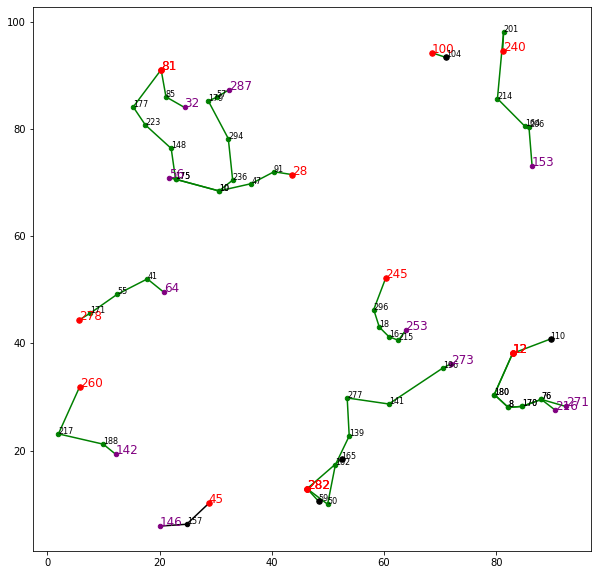

In [46]:
plt.figure(figsize=(10,10))
routes = {x:{} for x in veiculos.index}  
routes2= []
for i in _Solution:
        aux = i.split("_")[1:]
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        
for i in _Solution2.as_dict():
        aux = i.split("_")[1:]
        routes2.append((int(aux[0]),int(aux[1])))
        
atendimentos = {}
arc_count = {}
for k in veiculos.index:
    if len(routes[k]) > 0:
        
        inicial = veiculos.loc[k]["Inicial"]
        actual_node = routes[k].pop(inicial)
        
       
        xcoord=[pontos.loc[inicial]["x"],pontos.loc[actual_node]["x"]]
        ycoord=[pontos.loc[inicial]["y"],pontos.loc[actual_node]["y"]]
        
        if (inicial,actual_node) in routes2:
            plt.scatter(xcoord[0],ycoord[0],s=30,color='red',zorder=1)
            plt.text(xcoord[0],ycoord[0],str(inicial),fontsize=12,color="red")
            plt.plot(xcoord,ycoord,'g',zorder=0)
        else:
            plt.scatter(xcoord[0],ycoord[0],s=30,color='red',zorder=1)
            plt.text(xcoord[0],ycoord[0],str(inicial),fontsize=12,color="red")
            plt.plot(xcoord,ycoord,'black',zorder=0)
        
        if len(routes[k]) == 0:
            plt.scatter(xcoord[1],ycoord[1],s=30,color='black',zorder=1)
            plt.text(xcoord[1],ycoord[1],str(actual_node),fontsize=8,color="black")
        else:
            while actual_node not in vitimas["Ponto"].values:
                next_node = routes[k].pop(actual_node)

                if (actual_node,next_node) not in list(arc_count.keys()):
                    arc_count[(actual_node,next_node)]= 1
                else:
                    arc_count[(actual_node,next_node)]+= 1
                
                string+="-> "+str(next_node)


                xcoord=[pontos.loc[actual_node]["x"],pontos.loc[next_node]["x"]]
                ycoord=[pontos.loc[actual_node]["y"],pontos.loc[next_node]["y"]]
                
                if (actual_node, next_node) in routes2:
                    plt.scatter(xcoord[0],ycoord[0],s=20,color='g',zorder=1)
                    plt.text(xcoord[0],ycoord[0],str(actual_node),fontsize=8)
                    plt.plot(xcoord,ycoord,'g',zorder=0)
                    
                else:
                    plt.scatter(xcoord[0],ycoord[0],s=20,color='black',zorder=1)
                    plt.text(xcoord[0],ycoord[0],str(actual_node),fontsize=8)
                    plt.plot(xcoord,ycoord,'black',zorder=0)

                actual_node=next_node
                
            plt.scatter(xcoord[1],ycoord[1],s=20,color='purple',zorder=1)
            plt.text(xcoord[1],ycoord[1],str(next_node),fontsize=12,color='purple')
        
plt.show()